In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import scipy

In [2]:
#dataset import
test_data = pd.read_csv("test.csv")
train_data = pd.read_csv("train.csv")
validation_data = pd.read_csv("validation.csv")

In [3]:
#basic methods for "bidding" in validation set and training set
#takes in bid price and budget as parameters, tracks for bid >= payprice and deducts from budget if true
#returns CTR (won bids with click == 1 / all bids won)
def bid_con_val(price, budget):
    counter = 0
    get_bid = []
    while ((budget >= 0) & (counter < len(validation_data))):
        if(validation_data['payprice'][counter] <= price):
            budget -= validation_data['payprice'][counter]
            get_bid.append(validation_data['click'][counter])
        counter += 1
    return get_bid.count(1)

def bid_con_train(price, budget):
    counter = 0
    get_bid = []
    while ((budget >= 0) & (counter < len(subtrain))):
        if(subtrain['payprice'][counter] <= price):
            budget -= subtrain['payprice'][counter]
            get_bid.append(subtrain['click'][counter])
        counter += 1
    return get_bid.count(1)

#constant bidding on validation set with evaluation metrics output
def bid_con_val_bud(price, budget):
    counter = 0
    get_bid = []
    p_spent = []
    c_spent = []
    while ((budget >= 0) & (counter < len(validation_data))):
        if(validation_data['payprice'][counter] <= price):
            budget -= validation_data['payprice'][counter]
            p_spent.append(validation_data['payprice'][counter])
            get_bid.append(validation_data['click'][counter])
            if(validation_data['click'][counter] == 1):
                c_spent.append(validation_data['payprice'][counter])
        counter += 1
    print("clicks: " , get_bid.count(1))
    print("CTR: ", get_bid.count(1)/len(get_bid))
    print("CPM: ", np.mean(p_spent))
    print("CPC: ", np.mean(c_spent))

#sampling a training set that is closer to the size of validation set
subtrain = train_data.sample(300000)
subtrain = subtrain.reset_index()

In [5]:
#constant value declarations
budget = 6250000

In [445]:
#exploration of 10 bid increments
result_list_n = []
for i in range (0, 300, 10):
    result_list_n.append(bid_con_train(i, budget))

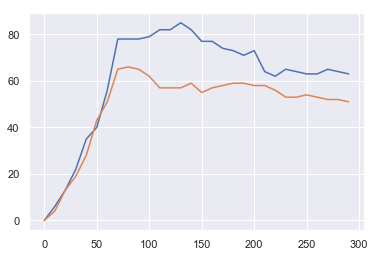

In [464]:
plt.plot(range(0,300,10),result_list_n)
plt.plot(range(0,300,10),result_list_v)

In [6]:
#optimal constant bid defined as 127, see item_constant.png
#visually defining optimal random range to be within 100 - 150
bid_con_val_bud(127, budget)

clicks:  57
CTR:  0.000496926899437688
CPM:  54.487772982869096
CPC:  67.05263157894737


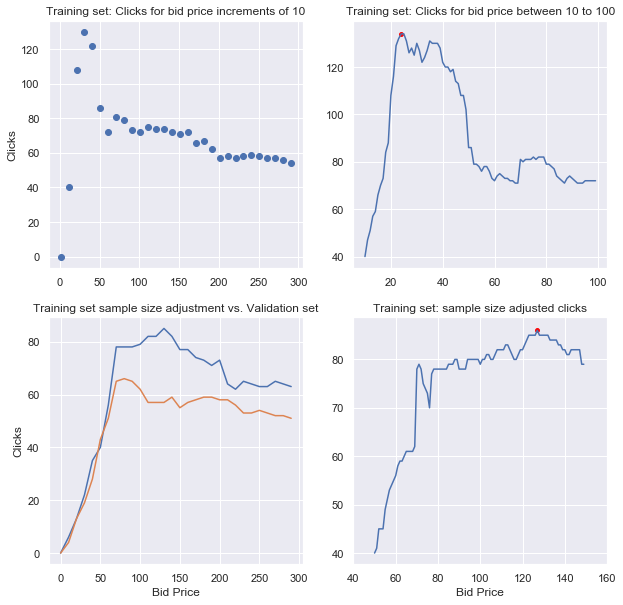

In [555]:
sns.set()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 2, 1)
plt.scatter(range(1,300,10),result_list_c)
plt.ylabel("Clicks")
plt.title("Training set: Clicks for bid price increments of 10")

ax = fig.add_subplot(2, 2, 2)
plt.plot(range(10,100,1),result_list_c_full)
plt.scatter(range(10,100,1)[result_list_c_full.index(max(result_list_c_full))], np.max(result_list_c_full), s = 15
            , color = 'red')
plt.title("Training set: Clicks for bid price between 10 to 100")

ax = fig.add_subplot(2, 2, 3)
plt.plot(range(0,300,10),result_list_n)
plt.plot(range(0,300,10),result_list_v)
plt.xlabel("Bid Price")
plt.ylabel("Clicks")
plt.title("Training set sample size adjustment vs. Validation set")

ax = fig.add_subplot(2, 2, 4)
plt.plot(range(50,150,1), result_list_n_2)
plt.scatter(range(50,150,1)[result_list_n_2.index(max(result_list_n_2))], np.max(result_list_n_2), s = 15
            , color = 'red')
plt.xlim(40,160)
plt.title("Training set: sample size adjusted clicks")
plt.xlabel("Bid Price")

plt.savefig('item_constant.png', dpi = 300)

In [7]:
#method for random bidding on validation set
#takes a bid_range parameter [lowerbound, upperbound]
random_range = [100,150]
random_range_2 = [110,140]
random_range_3 = [120,130]

def bid_rand_val(bid_range, budget):
    counter = 0
    get_bid = []
    p_spent = []
    c_spent = []
    while ((budget >= 0) & (counter < len(validation_data))):
        price = np.random.randint(bid_range[0],bid_range[1])
        if(validation_data['payprice'][counter] <= price):
            budget -= validation_data['payprice'][counter]
            p_spent.append(validation_data['payprice'][counter])
            get_bid.append(validation_data['click'][counter])
            if(validation_data['click'][counter] == 1):
                c_spent.append(validation_data['payprice'][counter])
        counter += 1
    print("clicks: " , get_bid.count(1))
    print("CTR: ", get_bid.count(1)/len(get_bid))
    print("CPM: ", np.mean(p_spent))
    print("CPC: ", np.mean(c_spent))

def bid_rand_train(bid_range, budget):
    counter = 0
    get_bid = []
    while ((budget >= 0) & (counter < len(subtrain))):
        price = np.random.randint(bid_range[0],bid_range[1])
        if(subtrain['payprice'][counter] <= price):
            budget -= subtrain['payprice'][counter]
            get_bid.append(subtrain['click'][counter])
        counter += 1
    return get_bid.count(1)

In [12]:
#exploring different clicks obtained with different ranges
#results may differ everytime ran as bidding values are random
bid_rand_val(random_range_3, budget)
bid_rand_val(random_range_2, budget)
bid_rand_val(random_range, budget)

clicks:  58
CTR:  0.0005012054856076252
CPM:  54.00922909411429
CPC:  67.22413793103448
clicks:  55
CTR:  0.00047542074736141483
CPM:  54.02581966858852
CPC:  64.21818181818182
clicks:  59
CTR:  0.0005105307789488258
CPM:  54.081953169617364
CPC:  68.66101694915254


In [772]:
#multi-agent random bidding
import random
import heapq


def bid_result(n_agent, win_index, counter):
    temp_r = np.zeros(n_agent)
    if(validation_data['click'][counter] == 0):
        temp_r[win_index] = 1
    else:
        temp_r[win_index] = 2
    
    return temp_r


def bid_rand_val_m(agent_num, bid_range, budget):
    counter = 0
    agent_budget = [budget] * agent_num
    get_bid = []
    win_price = []

    while ((any(x > 0 for x in agent_budget)) & (counter < len(validation_data))):
        agent_bids = random.choices(range(bid_range[0],bid_range[1]), k = agent_num)
        #check for budget
        for i in range(agent_num):
            #set their bid to 0 if they run out of budget
            if agent_budget[i] <= 0:
                agent_bids[i] = 0

        if(any(y >= validation_data['payprice'][counter] for y in agent_bids)):
            #add payprice to list of bid prices to compare
            agent_bids.append(validation_data['payprice'][counter])
            #deduct second price from winning bid's budget
            agent_budget[agent_bids.index(max(agent_bids))] -= heapq.nlargest(2, agent_bids)[1]
            #return bid results
            get_bid.append(bid_result(agent_num, agent_bids.index(max(agent_bids)), counter))
            win_price.append([heapq.nlargest(2, agent_bids)[0], agent_num])
        counter += 1
    
    fin_count = []
    win_count = []
    for i in range(agent_num):
        fin_count.append([row[i] for row in np.array(get_bid)].count(2))
        win_count.append([row[i] for row in np.array(get_bid)].count(1))
    
    return fin_count, win_count, win_price

In [773]:
#running random bidding with agent number ranging from 50-100
run_2_bid_results = []
run_2_bid_wins = []
run_2_win_price = []
for i in range(50,100,1):
    result = bid_rand_val_m(i, random_range, budget)
    run_2_bid_results.append(result[0])
    run_2_bid_wins.append(result[1])
    run_2_win_price.append(result[2])
    print(i)

50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


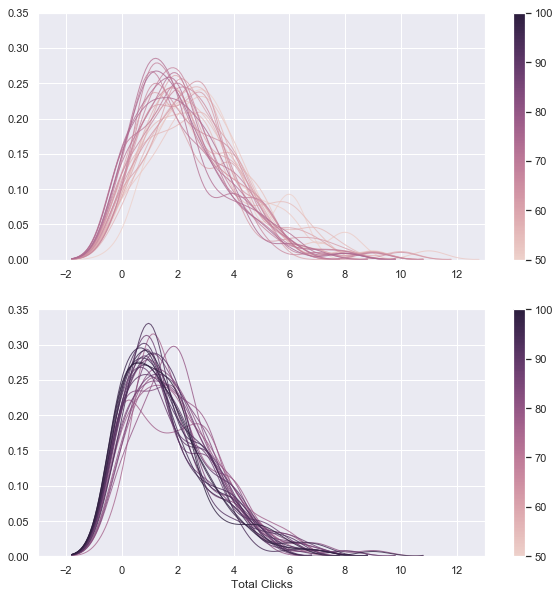

In [869]:
#plotting distribution of clicks obtained with color showing number of bidding agents
palette = sns.cubehelix_palette(50)
cmap = sns.cubehelix_palette(50, as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array(range(50,101,10))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 1, 1)
for i in range(0, 25,1):
    sns.distplot(run_2_bid_results[i], kde_kws = {"linewidth": 1, "alpha": 0.8, "color": palette[i], "bw":0.6},
                 bins =  [0,1,2,3,4,5,6,7], hist = None)
plt.ylim(0,0.35)
plt.xlim(-3,13)
ax.figure.colorbar(sm)

ax = fig.add_subplot(2, 1, 2)
for i in range(25, 50,1):
    sns.distplot(run_2_bid_results[i], hist = None, kde_kws = {"linewidth": 1, "alpha": 0.8, "color": palette[i], "bw":0.6})

plt.ylim(0,0.35)
plt.xlim(-3,13)
plt.xlabel("Total Clicks")
ax.figure.colorbar(sm)

plt.savefig('mult_rand.png', dpi = 300)

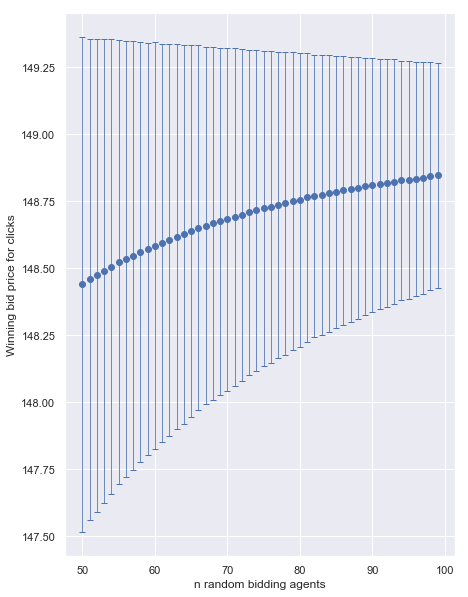

In [873]:
#plotting the change in win prices with their standard deviation with the increase in bidding agents

win_price = pd.DataFrame(run_2_win_price[0])
agent_bids = random.sample(range(random_range[0],random_range[1]), agent_num)

for i in range(1,len(run_2_win_price),1):
    win_price = win_price.join(pd.DataFrame(run_2_win_price[i]), rsuffix = i)
    
mean_win_p = win_price.filter(regex=("0")).mean(axis = 0)
std_win_p = win_price.filter(regex=("0")).std()

fig = plt.figure(figsize=(7,10))
plt.errorbar(x = range(50,100,1), y = mean_win_p, yerr = std_win_p, capsize=3, fmt='o', elinewidth = 0.8)
plt.xlabel("n random bidding agents")
plt.ylabel("Winning bid price for clicks")

plt.savefig('rand_win_price.png', dpi = 300)